In [31]:
!python -V

Python 3.11.8


In [32]:
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [33]:
import mlflow
import mlflow.xgboost

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Airline-Flight-Prices-India")

<Experiment: artifact_location='/Users/l.g./Documents/Repo/ml_ops_retail_model_pipeline/model_tracking/mlruns/1', creation_time=1720060282276, experiment_id='1', last_update_time=1720060282276, lifecycle_stage='active', name='Airline-Flight-Prices-India', tags={}>

In [34]:
df = pd.read_csv('../retail_data/flight_dataset.csv')

In [35]:
df.head(n=5)

,Airline,Source,Destination,Total_Stops,Price,Date,Month,Year,Dep_hours,Dep_min,Arrival_hours,Arrival_min,Duration_hours,Duration_min
0,IndiGo,Banglore,New Delhi,0,3897,24,3,2019,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,2019,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,2019,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,2019,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,2019,16,50,21,35,4,45


In [36]:
df.shape

(10683, 14)

In [37]:
df['SO_DE'] = df['Source'] + '_' + df['Destination']

In [38]:
categorical = ['SO_DE'] #['Source', 'Destination']
numerical = ['Duration_hours']

In [39]:
df[categorical] = df[categorical].astype(str)

In [40]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [41]:
dv = DictVectorizer()
X = dv.fit_transform(train_dicts)

In [42]:
target = 'Price'
y = df[target].values

In [43]:
#y_train

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% training, 20% validation

In [45]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [46]:
y_pred = lr.predict(X_val)

/var/folders/tz/tx9cqhzx12d8m9rn6ksgbnhr0000gn/T/ipykernel_84372/1351390157.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/tz/tx9cqhzx12d8m9rn6ksgbnhr0000gn/T/ipykernel_84372/1351390157.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

<Axes: ylabel='Density'>

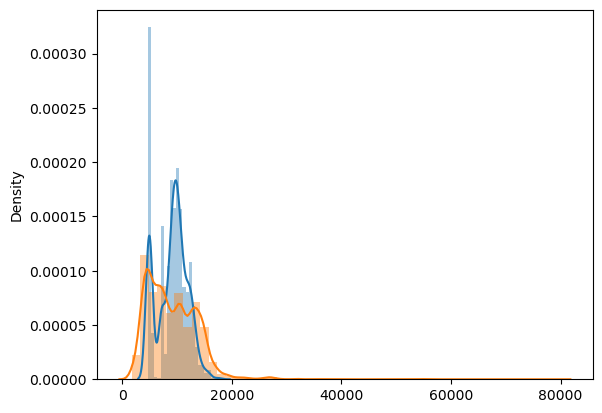

In [47]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

In [48]:
mean_squared_error(y_val, y_pred, squared=False)

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3697.485935178474

In [49]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error on validation set: {rmse}")

Root Mean Squared Error on validation set: 3697.485935178474


In [50]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [51]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Lamar")

    mlflow.log_param("training-data-path", "../retail_data/flight_dataset.csv")
    mlflow.log_param("validation-data-path", "../retail_data/flight_dataset.csv")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    ls = Lasso(alpha)
    ls.fit(X_train, y_train)
    
    y_pred = ls.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg_lasso.bin", artifact_path="models_pickle/")

In [52]:
with open('../models/lin_lasso_reg.bin', 'wb') as f_out:
    pickle.dump((dv, ls), f_out)

In [53]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [54]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [55]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=200,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)
        
    return {'loss': rmse, 'status': STATUS_OK}



In [56]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lamdba', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3), 
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials())

[0]	validation-rmse:4464.21682                                                                                                                               
[1]	validation-rmse:4341.02642                                                                                                                               
[2]	validation-rmse:4230.07764                                                                                                                               
[3]	validation-rmse:4130.34778                                                                                                                               
[4]	validation-rmse:4040.92965                                                                                                                               
[5]	validation-rmse:3960.92976                                                                                                                               
[6]	validation-rmse:3889.50340                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:39] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[38]	validation-rmse:3361.30784                                                                                                                              
[39]	validation-rmse:3360.52334                                                                                                                              
[40]	validation-rmse:3359.97679                                                                                                                              
[41]	validation-rmse:3359.42925                                                                                                                              
[42]	validation-rmse:3359.06659                                                                                                                              
[43]	validation-rmse:3358.66043                                                                                                                              
[44]	validation-rmse:3358.43298                     

2024/07/05 20:56:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:40] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4488.68414                                                                                                                               
[1]	validation-rmse:4385.44696                                                                                                                               
[2]	validation-rmse:4290.56421                                                                                                                               
[3]	validation-rmse:4203.49013                                                                                                                               
[4]	validation-rmse:4123.69965                                                                                                                               
[5]	validation-rmse:4050.68914                                                                                                                               
[6]	validation-rmse:3983.97677                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[37]	validation-rmse:3371.92756                                                                                                                              
[38]	validation-rmse:3369.58724                                                                                                                              
[39]	validation-rmse:3367.42111                                                                                                                              
[40]	validation-rmse:3365.57147                                                                                                                              
[41]	validation-rmse:3363.83721                                                                                                                              
[42]	validation-rmse:3362.38221                                                                                                                              
[43]	validation-rmse:3361.00579                     

2024/07/05 20:56:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4309.62274                                                                                                                               
[1]	validation-rmse:4080.38455                                                                                                                               
[2]	validation-rmse:3901.97341                                                                                                                               
[3]	validation-rmse:3764.58389                                                                                                                               
[4]	validation-rmse:3659.78022                                                                                                                               
[5]	validation-rmse:3580.53258                                                                                                                               
[6]	validation-rmse:3521.06732                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:43] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[27]	validation-rmse:3358.28393
[28]	validation-rmse:3358.41133                                                                                                                              
[29]	validation-rmse:3358.55888                                                                                                                              
[30]	validation-rmse:3358.68860                                                                                                                              
[31]	validation-rmse:3358.85329                                                                                                                              
[32]	validation-rmse:3359.09267                                                                                                                              
[33]	validation-rmse:3359.21439                                                                                                                              
[34]	validation-rmse

2024/07/05 20:56:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:44] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3825.91091                                                                                                                               
[1]	validation-rmse:3518.85519                                                                                                                               
[2]	validation-rmse:3408.87304                                                                                                                               
[3]	validation-rmse:3372.43177                                                                                                                               
[4]	validation-rmse:3361.49804                                                                                                                               
[5]	validation-rmse:3358.86795                                                                                                                               
[6]	validation-rmse:3358.68807                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:45] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[18]	validation-rmse:3360.31816                                                                                                                              
[19]	validation-rmse:3360.32029                                                                                                                              
[20]	validation-rmse:3360.32156                                                                                                                              
[21]	validation-rmse:3360.32232                                                                                                                              
[22]	validation-rmse:3360.32253                                                                                                                              
[23]	validation-rmse:3360.32279                                                                                                                              
[24]	validation-rmse:3360.32301                     

2024/07/05 20:56:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:45] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4106.96074                                                                                                                               
[1]	validation-rmse:3797.60734                                                                                                                               
[2]	validation-rmse:3610.26476                                                                                                                               
[3]	validation-rmse:3500.21645                                                                                                                               
[4]	validation-rmse:3437.10371                                                                                                                               
[5]	validation-rmse:3401.43867                                                                                                                               
[6]	validation-rmse:3381.26779                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:47] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[35]	validation-rmse:3361.37979                                                                                                                              
[36]	validation-rmse:3361.80860                                                                                                                              
[37]	validation-rmse:3360.52749                                                                                                                              
[38]	validation-rmse:3361.03834                                                                                                                              
[39]	validation-rmse:3361.65114                                                                                                                              
[40]	validation-rmse:3360.52331                                                                                                                              
[41]	validation-rmse:3360.84915                     

2024/07/05 20:56:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:47] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3492.22440                                                                                                                               
[1]	validation-rmse:3365.61926                                                                                                                               
[2]	validation-rmse:3355.54897                                                                                                                               
[3]	validation-rmse:3361.29883                                                                                                                               
[4]	validation-rmse:3359.65000                                                                                                                               
[5]	validation-rmse:3362.96372                                                                                                                               
[6]	validation-rmse:3356.67713                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:48] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:3362.04434                                                                                                                              
[48]	validation-rmse:3362.41493                                                                                                                              
[49]	validation-rmse:3362.32085                                                                                                                              
[50]	validation-rmse:3362.50526                                                                                                                              
[51]	validation-rmse:3362.28626                                                                                                                              
 10%|████████▊                                                                               | 5/50 [00:09<01:13,  1.63s/trial, best loss: 3355.118978248235]

2024/07/05 20:56:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:48] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4258.61641                                                                                                                               
[1]	validation-rmse:4002.78670                                                                                                                               
[2]	validation-rmse:3814.32249                                                                                                                               
[3]	validation-rmse:3678.65709                                                                                                                               
[4]	validation-rmse:3581.20504                                                                                                                               
[5]	validation-rmse:3512.41616                                                                                                                               
[6]	validation-rmse:3463.87133                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:49] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[43]	validation-rmse:3358.95215                                                                                                                              
[44]	validation-rmse:3358.68058                                                                                                                              
[45]	validation-rmse:3358.99355                                                                                                                              
[46]	validation-rmse:3358.73546                                                                                                                              
[47]	validation-rmse:3358.69745                                                                                                                              
[48]	validation-rmse:3358.47707                                                                                                                              
[49]	validation-rmse:3358.58015                     

2024/07/05 20:56:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:50] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4378.23070                                                                                                                               
[1]	validation-rmse:4191.53211                                                                                                                               
[2]	validation-rmse:4035.92849                                                                                                                               
[3]	validation-rmse:3906.85884                                                                                                                               
[4]	validation-rmse:3800.65960                                                                                                                               
[5]	validation-rmse:3714.07379                                                                                                                               
[6]	validation-rmse:3643.50417                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:51] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[39]	validation-rmse:3357.46875                                                                                                                              
[40]	validation-rmse:3358.07573                                                                                                                              
[41]	validation-rmse:3357.98297                                                                                                                              
[42]	validation-rmse:3358.58894                                                                                                                              
[43]	validation-rmse:3358.51508                                                                                                                              
[44]	validation-rmse:3359.05130                                                                                                                              
[45]	validation-rmse:3358.97642                     

2024/07/05 20:56:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:51] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3368.96080                                                                                                                               
[1]	validation-rmse:3350.99784                                                                                                                               
[2]	validation-rmse:3355.25421                                                                                                                               
[3]	validation-rmse:3356.14625                                                                                                                               
[4]	validation-rmse:3354.61861                                                                                                                               
[5]	validation-rmse:3355.90313                                                                                                                               
[6]	validation-rmse:3354.43729                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:53] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

2024/07/05 20:56:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:53] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4380.18796                                                                                                                               
[1]	validation-rmse:4194.84405                                                                                                                               
[2]	validation-rmse:4040.09442                                                                                                                               
[3]	validation-rmse:3911.49930                                                                                                                               
[4]	validation-rmse:3805.48717                                                                                                                               
[5]	validation-rmse:3718.30530                                                                                                                               
[6]	validation-rmse:3647.10259                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[35]	validation-rmse:3355.26714                                                                                                                              
[36]	validation-rmse:3355.83514                                                                                                                              
[37]	validation-rmse:3356.41865                                                                                                                              
[38]	validation-rmse:3356.98895                                                                                                                              
[39]	validation-rmse:3357.55007                                                                                                                              
[40]	validation-rmse:3358.06583                                                                                                                              
[41]	validation-rmse:3357.89523                     

2024/07/05 20:56:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:55] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4400.90075                                                                                                                               
[1]	validation-rmse:4229.77229                                                                                                                               
[2]	validation-rmse:4084.04469                                                                                                                               
[3]	validation-rmse:3960.55749                                                                                                                               
[4]	validation-rmse:3856.40738                                                                                                                               
[5]	validation-rmse:3768.95668                                                                                                                               
[6]	validation-rmse:3695.82806                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:56] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[22]	validation-rmse:3367.47650                                                                                                                              
[23]	validation-rmse:3365.29291                                                                                                                              
[24]	validation-rmse:3363.57926                                                                                                                              
[25]	validation-rmse:3362.24763                                                                                                                              
[26]	validation-rmse:3361.21723                                                                                                                              
[27]	validation-rmse:3360.43212                                                                                                                              
[28]	validation-rmse:3359.84908                     

2024/07/05 20:56:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:57] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4413.81041                                                                                                                               
[1]	validation-rmse:4251.94067                                                                                                                               
[2]	validation-rmse:4112.46207                                                                                                                               
[3]	validation-rmse:3992.79153                                                                                                                               
[4]	validation-rmse:3890.54892                                                                                                                               
[5]	validation-rmse:3803.53807                                                                                                                               
[6]	validation-rmse:3729.75369                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:58] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:3358.82475                                                                                                                              
[42]	validation-rmse:3358.88895                                                                                                                              
[43]	validation-rmse:3358.95864                                                                                                                              
[44]	validation-rmse:3359.03117                                                                                                                              
[45]	validation-rmse:3359.10481                                                                                                                              
[46]	validation-rmse:3359.17902                                                                                                                              
[47]	validation-rmse:3359.25130                     

2024/07/05 20:56:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:58] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3704.72835                                                                                                                               
[1]	validation-rmse:3441.06727                                                                                                                               
[2]	validation-rmse:3374.89284                                                                                                                               
[3]	validation-rmse:3359.64209                                                                                                                               
[4]	validation-rmse:3356.15715                                                                                                                               
[5]	validation-rmse:3357.78948                                                                                                                               
[6]	validation-rmse:3357.45116                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:59] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

2024/07/05 20:56:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:56:59] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4450.25691                                                                                                                               
[1]	validation-rmse:4315.95968                                                                                                                               
[2]	validation-rmse:4196.49075                                                                                                                               
[3]	validation-rmse:4090.55822                                                                                                                               
[4]	validation-rmse:3996.81335                                                                                                                               
[5]	validation-rmse:3914.10871                                                                                                                               
[6]	validation-rmse:3841.24917                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:01] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[50]	validation-rmse:3356.37924                                                                                                                              
[51]	validation-rmse:3356.21878                                                                                                                              
[52]	validation-rmse:3356.42595                                                                                                                              
[53]	validation-rmse:3356.65145                                                                                                                              
[54]	validation-rmse:3356.91190                                                                                                                              
[55]	validation-rmse:3357.16149                                                                                                                              
[56]	validation-rmse:3357.41050                     

2024/07/05 20:57:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:01] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4137.46687                                                                                                                               
[1]	validation-rmse:3834.13229                                                                                                                               
[2]	validation-rmse:3640.97807                                                                                                                               
[3]	validation-rmse:3520.48804                                                                                                                               
[4]	validation-rmse:3448.05674                                                                                                                               
[5]	validation-rmse:3404.40446                                                                                                                               
[6]	validation-rmse:3379.55354                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:02] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:3360.10890                                                                                                                              
[35]	validation-rmse:3359.97363                                                                                                                              
[36]	validation-rmse:3360.34935                                                                                                                              
[37]	validation-rmse:3359.23129                                                                                                                              
[38]	validation-rmse:3359.12025                                                                                                                              
[39]	validation-rmse:3359.74183                                                                                                                              
[40]	validation-rmse:3359.61544                     

2024/07/05 20:57:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4452.85968                                                                                                                               
[1]	validation-rmse:4320.62299                                                                                                                               
[2]	validation-rmse:4202.60253                                                                                                                               
[3]	validation-rmse:4097.60961                                                                                                                               
[4]	validation-rmse:4004.15283                                                                                                                               
[5]	validation-rmse:3921.61869                                                                                                                               
[6]	validation-rmse:3848.50203                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:04] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[40]	validation-rmse:3352.26507                                                                                                                              
[41]	validation-rmse:3352.09541                                                                                                                              
[42]	validation-rmse:3351.85089                                                                                                                              
[43]	validation-rmse:3351.70728                                                                                                                              
[44]	validation-rmse:3351.61266                                                                                                                              
[45]	validation-rmse:3351.59418                                                                                                                              
[46]	validation-rmse:3351.57972                     

2024/07/05 20:57:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:04] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4146.50148                                                                                                                               
[1]	validation-rmse:3845.83916                                                                                                                               
[2]	validation-rmse:3652.05449                                                                                                                               
[3]	validation-rmse:3529.60845                                                                                                                               
[4]	validation-rmse:3454.08400                                                                                                                               
[5]	validation-rmse:3409.39268                                                                                                                               
[6]	validation-rmse:3383.10861                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[56]	validation-rmse:3358.60846                                                                                                                              
[57]	validation-rmse:3358.44480                                                                                                                              
[58]	validation-rmse:3358.75212                                                                                                                              
[59]	validation-rmse:3358.54132                                                                                                                              
[60]	validation-rmse:3358.55440                                                                                                                              
[61]	validation-rmse:3358.41540                                                                                                                              
 32%|███████████████████████████▊                   

2024/07/05 20:57:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:06] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4458.44080                                                                                                                               
[1]	validation-rmse:4330.46345                                                                                                                               
[2]	validation-rmse:4215.76657                                                                                                                               
[3]	validation-rmse:4113.21960                                                                                                                               
[4]	validation-rmse:4021.46455                                                                                                                               
[5]	validation-rmse:3939.99882                                                                                                                               
[6]	validation-rmse:3867.54709                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[54]	validation-rmse:3352.70452                                                                                                                              
[55]	validation-rmse:3352.76712                                                                                                                              
[56]	validation-rmse:3352.97562                                                                                                                              
[57]	validation-rmse:3353.19903                                                                                                                              
[58]	validation-rmse:3353.39770                                                                                                                              
[59]	validation-rmse:3353.63188                                                                                                                              
[60]	validation-rmse:3353.81961                     

2024/07/05 20:57:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3975.00514                                                                                                                               
[1]	validation-rmse:3648.32063                                                                                                                               
[2]	validation-rmse:3488.69407                                                                                                                               
[3]	validation-rmse:3414.04784                                                                                                                               
[4]	validation-rmse:3380.49352                                                                                                                               
[5]	validation-rmse:3365.57614                                                                                                                               
[6]	validation-rmse:3360.16889                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:09] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:3361.66156                                                                                                                              
[42]	validation-rmse:3361.72819                                                                                                                              
[43]	validation-rmse:3361.72401                                                                                                                              
[44]	validation-rmse:3361.78049                                                                                                                              
[45]	validation-rmse:3361.78415                                                                                                                              
[46]	validation-rmse:3361.83648                                                                                                                              
[47]	validation-rmse:3361.81621                     

2024/07/05 20:57:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:09] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4444.46145                                                                                                                               
[1]	validation-rmse:4305.68087                                                                                                                               
[2]	validation-rmse:4182.86005                                                                                                                               
[3]	validation-rmse:4074.50755                                                                                                                               
[4]	validation-rmse:3979.18575                                                                                                                               
[5]	validation-rmse:3895.54495                                                                                                                               
[6]	validation-rmse:3822.34219                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:10] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[50]	validation-rmse:3359.47410
[51]	validation-rmse:3359.45273                                                                                                                              
[52]	validation-rmse:3359.45928                                                                                                                              
[53]	validation-rmse:3359.48921                                                                                                                              
[54]	validation-rmse:3359.68471                                                                                                                              
[55]	validation-rmse:3359.81332                                                                                                                              
[56]	validation-rmse:3359.88116                                                                                                                              
[57]	validation-rmse

2024/07/05 20:57:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:11] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4487.67311                                                                                                                               
[1]	validation-rmse:4383.61036                                                                                                                               
[2]	validation-rmse:4288.06600                                                                                                                               
[3]	validation-rmse:4200.47624                                                                                                                               
[4]	validation-rmse:4120.29608                                                                                                                               
[5]	validation-rmse:4047.01170                                                                                                                               
[6]	validation-rmse:3980.12600                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:12] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[44]	validation-rmse:3363.35696                                                                                                                              
[45]	validation-rmse:3362.55093                                                                                                                              
[46]	validation-rmse:3361.75347                                                                                                                              
[47]	validation-rmse:3361.15715                                                                                                                              
[48]	validation-rmse:3360.54938                                                                                                                              
[49]	validation-rmse:3360.12569                                                                                                                              
[50]	validation-rmse:3359.66634                     

2024/07/05 20:57:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:12] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4329.45016                                                                                                                               
[1]	validation-rmse:4111.85057                                                                                                                               
[2]	validation-rmse:3938.69454                                                                                                                               
[3]	validation-rmse:3802.70651                                                                                                                               
[4]	validation-rmse:3697.12410                                                                                                                               
[5]	validation-rmse:3615.40208                                                                                                                               
[6]	validation-rmse:3552.57095                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:14] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[33]	validation-rmse:3358.52158                                                                                                                              
[34]	validation-rmse:3358.14284                                                                                                                              
[35]	validation-rmse:3358.22380                                                                                                                              
[36]	validation-rmse:3357.77781                                                                                                                              
[37]	validation-rmse:3358.02667                                                                                                                              
[38]	validation-rmse:3357.91225                                                                                                                              
[39]	validation-rmse:3358.52813                     

2024/07/05 20:57:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:14] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4487.35854                                                                                                                               
[1]	validation-rmse:4383.06442                                                                                                                               
[2]	validation-rmse:4287.35866                                                                                                                               
[3]	validation-rmse:4199.65612                                                                                                                               
[4]	validation-rmse:4119.41370                                                                                                                               
[5]	validation-rmse:4046.02625                                                                                                                               
[6]	validation-rmse:3979.16047                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:15] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:3366.01209                                                                                                                              
[42]	validation-rmse:3364.59211                                                                                                                              
[43]	validation-rmse:3363.50267                                                                                                                              
[44]	validation-rmse:3362.46775                                                                                                                              
[45]	validation-rmse:3361.49104                                                                                                                              
[46]	validation-rmse:3360.69769                                                                                                                              
[47]	validation-rmse:3359.89270                     

2024/07/05 20:57:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4261.33831                                                                                                                               
[1]	validation-rmse:4006.48924                                                                                                                               
[2]	validation-rmse:3818.18054                                                                                                                               
[3]	validation-rmse:3681.02162                                                                                                                               
[4]	validation-rmse:3582.37157                                                                                                                               
[5]	validation-rmse:3512.88251                                                                                                                               
[6]	validation-rmse:3463.98152                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:17] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[39]	validation-rmse:3355.00367                                                                                                                              
[40]	validation-rmse:3355.39570                                                                                                                              
[41]	validation-rmse:3355.42008                                                                                                                              
[42]	validation-rmse:3355.37175                                                                                                                              
[43]	validation-rmse:3355.35690                                                                                                                              
[44]	validation-rmse:3355.79100                                                                                                                              
[45]	validation-rmse:3355.80528                     

2024/07/05 20:57:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4238.09698                                                                                                                               
[1]	validation-rmse:3972.55812                                                                                                                               
[2]	validation-rmse:3781.67370                                                                                                                               
[3]	validation-rmse:3646.70666                                                                                                                               
[4]	validation-rmse:3552.63082                                                                                                                               
[5]	validation-rmse:3487.86158                                                                                                                               
[6]	validation-rmse:3443.17549                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[35]	validation-rmse:3360.31435                                                                                                                              
[36]	validation-rmse:3360.29905                                                                                                                              
[37]	validation-rmse:3360.38238                                                                                                                              
[38]	validation-rmse:3360.36712                                                                                                                              
[39]	validation-rmse:3360.51131                                                                                                                              
[40]	validation-rmse:3360.43582                                                                                                                              
[41]	validation-rmse:3360.56934                     

2024/07/05 20:57:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3930.32021                                                                                                                               
[1]	validation-rmse:3605.27918                                                                                                                               
[2]	validation-rmse:3460.04960                                                                                                                               
[3]	validation-rmse:3397.64902                                                                                                                               
[4]	validation-rmse:3369.94599                                                                                                                               
[5]	validation-rmse:3358.35176                                                                                                                               
[6]	validation-rmse:3354.52878                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[41]	validation-rmse:3357.58831                                                                                                                              
[42]	validation-rmse:3357.68447                                                                                                                              
[43]	validation-rmse:3357.92587                                                                                                                              
[44]	validation-rmse:3357.80498                                                                                                                              
[45]	validation-rmse:3357.84338                                                                                                                              
[46]	validation-rmse:3357.98201                                                                                                                              
[47]	validation-rmse:3358.30856                     

2024/07/05 20:57:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:21] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3608.75721                                                                                                                               
[1]	validation-rmse:3394.45523                                                                                                                               
[2]	validation-rmse:3350.14827                                                                                                                               
[3]	validation-rmse:3342.69351                                                                                                                               
[4]	validation-rmse:3338.62417                                                                                                                               
[5]	validation-rmse:3340.04990                                                                                                                               
[6]	validation-rmse:3340.98183                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:22] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[52]	validation-rmse:3354.40416                                                                                                                              
[53]	validation-rmse:3355.16639                                                                                                                              
 52%|█████████████████████████████████████████████▏                                         | 26/50 [00:42<00:38,  1.60s/trial, best loss: 3355.118978248235]

2024/07/05 20:57:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:22] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3352.58051                                                                                                                               
[1]	validation-rmse:3356.78733                                                                                                                               
[2]	validation-rmse:3356.48923                                                                                                                               
[3]	validation-rmse:3357.05047                                                                                                                               
[4]	validation-rmse:3355.68743                                                                                                                               
[5]	validation-rmse:3355.90223                                                                                                                               
[6]	validation-rmse:3356.29114                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

2024/07/05 20:57:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:24] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3696.95569                                                                                                                               
[1]	validation-rmse:3437.87419                                                                                                                               
[2]	validation-rmse:3372.79541                                                                                                                               
[3]	validation-rmse:3359.96080                                                                                                                               
[4]	validation-rmse:3357.74679                                                                                                                               
[5]	validation-rmse:3358.53218                                                                                                                               
[6]	validation-rmse:3359.09911                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[42]	validation-rmse:3362.33592                                                                                                                              
[43]	validation-rmse:3362.37062                                                                                                                              
[44]	validation-rmse:3362.36582                                                                                                                              
[45]	validation-rmse:3362.38982                                                                                                                              
[46]	validation-rmse:3362.38367                                                                                                                              
[47]	validation-rmse:3362.40927                                                                                                                              
[48]	validation-rmse:3362.39819                     

2024/07/05 20:57:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3427.57673                                                                                                                               
[1]	validation-rmse:3353.10165                                                                                                                               
[2]	validation-rmse:3353.02179                                                                                                                               
[3]	validation-rmse:3355.95052                                                                                                                               
[4]	validation-rmse:3355.86821                                                                                                                               
[5]	validation-rmse:3355.53149                                                                                                                               
[6]	validation-rmse:3356.06116                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:26] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[45]	validation-rmse:3361.87642                                                                                                                              
[46]	validation-rmse:3361.99590                                                                                                                              
[47]	validation-rmse:3361.98753                                                                                                                              
[48]	validation-rmse:3361.96450                                                                                                                              
[49]	validation-rmse:3361.99647                                                                                                                              
[50]	validation-rmse:3362.08717                                                                                                                              
[51]	validation-rmse:3362.02715                     

2024/07/05 20:57:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3534.66666                                                                                                                               
[1]	validation-rmse:3368.88256                                                                                                                               
[2]	validation-rmse:3351.04765                                                                                                                               
[3]	validation-rmse:3350.82421                                                                                                                               
[4]	validation-rmse:3352.77332                                                                                                                               
[5]	validation-rmse:3353.70085                                                                                                                               
[6]	validation-rmse:3354.26956                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:28] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

2024/07/05 20:57:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:28] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3740.24407                                                                                                                               
[1]	validation-rmse:3459.81881                                                                                                                               
[2]	validation-rmse:3374.62729                                                                                                                               
[3]	validation-rmse:3350.62029                                                                                                                               
[4]	validation-rmse:3347.00817                                                                                                                               
[5]	validation-rmse:3341.30502                                                                                                                               
[6]	validation-rmse:3340.69838                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

2024/07/05 20:57:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3996.20239                                                                                                                               
[1]	validation-rmse:3670.37317                                                                                                                               
[2]	validation-rmse:3506.42199                                                                                                                               
[3]	validation-rmse:3426.81861                                                                                                                               
[4]	validation-rmse:3389.17749                                                                                                                               
[5]	validation-rmse:3369.72884                                                                                                                               
[6]	validation-rmse:3362.70571                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[40]	validation-rmse:3357.75110                                                                                                                              
[41]	validation-rmse:3358.18287                                                                                                                              
[42]	validation-rmse:3358.64759                                                                                                                              
[43]	validation-rmse:3358.15418                                                                                                                              
[44]	validation-rmse:3358.56190                                                                                                                              
[45]	validation-rmse:3359.02675                                                                                                                              
[46]	validation-rmse:3358.91556                     

2024/07/05 20:57:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3826.37971                                                                                                                               
[1]	validation-rmse:3519.32388                                                                                                                               
[2]	validation-rmse:3408.03125                                                                                                                               
[3]	validation-rmse:3370.99509                                                                                                                               
[4]	validation-rmse:3359.09070                                                                                                                               
[5]	validation-rmse:3355.79318                                                                                                                               
[6]	validation-rmse:3354.16806                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:3358.94051                                                                                                                              
[48]	validation-rmse:3359.32157                                                                                                                              
[49]	validation-rmse:3359.52534                                                                                                                              
[50]	validation-rmse:3359.77097                                                                                                                              
[51]	validation-rmse:3359.48579                                                                                                                              
[52]	validation-rmse:3359.79961                                                                                                                              
[53]	validation-rmse:3360.13075                     

2024/07/05 20:57:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3802.37359                                                                                                                               
[1]	validation-rmse:3504.07884                                                                                                                               
[2]	validation-rmse:3403.44264                                                                                                                               
[3]	validation-rmse:3371.55977                                                                                                                               
[4]	validation-rmse:3363.12486                                                                                                                               
[5]	validation-rmse:3361.07571                                                                                                                               
[6]	validation-rmse:3360.18111                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:34] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[38]	validation-rmse:3359.09263                                                                                                                              
[39]	validation-rmse:3359.31298                                                                                                                              
[40]	validation-rmse:3359.72277                                                                                                                              
[41]	validation-rmse:3358.54600                                                                                                                              
[42]	validation-rmse:3359.01421                                                                                                                              
[43]	validation-rmse:3359.97007                                                                                                                              
[44]	validation-rmse:3359.36451                     

2024/07/05 20:57:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:34] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4059.47756                                                                                                                               
[1]	validation-rmse:3739.75078                                                                                                                               
[2]	validation-rmse:3560.95197                                                                                                                               
[3]	validation-rmse:3463.75409                                                                                                                               
[4]	validation-rmse:3411.98013                                                                                                                               
[5]	validation-rmse:3383.10108                                                                                                                               
[6]	validation-rmse:3369.93621                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[34]	validation-rmse:3357.53878
[35]	validation-rmse:3357.03900                                                                                                                              
[36]	validation-rmse:3357.73570                                                                                                                              
[37]	validation-rmse:3357.66000                                                                                                                              
[38]	validation-rmse:3357.29323                                                                                                                              
[39]	validation-rmse:3357.40312                                                                                                                              
[40]	validation-rmse:3358.06898                                                                                                                              
[41]	validation-rmse

2024/07/05 20:57:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:36] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3417.41869                                                                                                                               
[1]	validation-rmse:3357.69120                                                                                                                               
[2]	validation-rmse:3359.11151                                                                                                                               
[3]	validation-rmse:3359.64876                                                                                                                               
[4]	validation-rmse:3360.05083                                                                                                                               
[5]	validation-rmse:3360.88156                                                                                                                               
[6]	validation-rmse:3360.53021                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:37] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[38]	validation-rmse:3362.45622
[39]	validation-rmse:3362.46023                                                                                                                              
[40]	validation-rmse:3362.46275                                                                                                                              
[41]	validation-rmse:3362.46274                                                                                                                              
[42]	validation-rmse:3362.46213                                                                                                                              
[43]	validation-rmse:3362.46485                                                                                                                              
[44]	validation-rmse:3362.46300                                                                                                                              
[45]	validation-rmse

2024/07/05 20:57:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:37] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4194.28447                                                                                                                               
[1]	validation-rmse:3911.27516                                                                                                                               
[2]	validation-rmse:3718.69771                                                                                                                               
[3]	validation-rmse:3590.10841                                                                                                                               
[4]	validation-rmse:3505.91255                                                                                                                               
[5]	validation-rmse:3451.29726                                                                                                                               
[6]	validation-rmse:3416.55931                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:39] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[50]	validation-rmse:3361.10272                                                                                                                              
[51]	validation-rmse:3361.15816                                                                                                                              
[52]	validation-rmse:3361.48012                                                                                                                              
[53]	validation-rmse:3360.60017                                                                                                                              
[54]	validation-rmse:3360.84685                                                                                                                              
[55]	validation-rmse:3360.60802                                                                                                                              
[56]	validation-rmse:3360.21774                     

2024/07/05 20:57:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:39] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3897.27266                                                                                                                               
[1]	validation-rmse:3576.35267                                                                                                                               
[2]	validation-rmse:3441.19809                                                                                                                               
[3]	validation-rmse:3387.58842                                                                                                                               
[4]	validation-rmse:3367.55808                                                                                                                               
[5]	validation-rmse:3360.73286                                                                                                                               
[6]	validation-rmse:3358.84686                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:40] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[32]	validation-rmse:3360.32202                                                                                                                              
[33]	validation-rmse:3360.32218                                                                                                                              
[34]	validation-rmse:3360.32227                                                                                                                              
[35]	validation-rmse:3360.32228                                                                                                                              
[36]	validation-rmse:3360.32232                                                                                                                              
[37]	validation-rmse:3360.32234                                                                                                                              
[38]	validation-rmse:3360.32233                     

2024/07/05 20:57:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4332.73843                                                                                                                               
[1]	validation-rmse:4116.86672                                                                                                                               
[2]	validation-rmse:3944.68526                                                                                                                               
[3]	validation-rmse:3808.57145                                                                                                                               
[4]	validation-rmse:3701.85050                                                                                                                               
[5]	validation-rmse:3618.79444                                                                                                                               
[6]	validation-rmse:3555.19057                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[31]	validation-rmse:3354.47436                                                                                                                              
[32]	validation-rmse:3354.82440                                                                                                                              
[33]	validation-rmse:3354.79737                                                                                                                              
[34]	validation-rmse:3355.10554                                                                                                                              
[35]	validation-rmse:3354.77925                                                                                                                              
[36]	validation-rmse:3355.07292                                                                                                                              
[37]	validation-rmse:3354.73965                     

2024/07/05 20:57:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:43] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3705.82525                                                                                                                               
[1]	validation-rmse:3442.07992                                                                                                                               
[2]	validation-rmse:3372.60267                                                                                                                               
[3]	validation-rmse:3350.20133                                                                                                                               
[4]	validation-rmse:3341.06932                                                                                                                               
[5]	validation-rmse:3339.20917                                                                                                                               
[6]	validation-rmse:3336.58965                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:44] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[37]	validation-rmse:3350.45940                                                                                                                              
[38]	validation-rmse:3350.58757                                                                                                                              
[39]	validation-rmse:3351.65364                                                                                                                              
[40]	validation-rmse:3351.67165                                                                                                                              
[41]	validation-rmse:3351.60609                                                                                                                              
[42]	validation-rmse:3351.64835                                                                                                                              
[43]	validation-rmse:3351.84961                     

2024/07/05 20:57:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:44] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3351.05443                                                                                                                               
[1]	validation-rmse:3329.17614                                                                                                                               
[2]	validation-rmse:3347.47459                                                                                                                               
[3]	validation-rmse:3349.72803                                                                                                                               
[4]	validation-rmse:3357.41074                                                                                                                               
[5]	validation-rmse:3356.15545                                                                                                                               
[6]	validation-rmse:3354.51184                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:45] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

2024/07/05 20:57:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:46] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3659.86937                                                                                                                               
[1]	validation-rmse:3420.07585                                                                                                                               
[2]	validation-rmse:3368.35369                                                                                                                               
[3]	validation-rmse:3359.40826                                                                                                                               
[4]	validation-rmse:3358.74877                                                                                                                               
[5]	validation-rmse:3359.22438                                                                                                                               
[6]	validation-rmse:3359.72009                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:47] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[40]	validation-rmse:3360.32310                                                                                                                              
[41]	validation-rmse:3360.32310                                                                                                                              
[42]	validation-rmse:3360.32310                                                                                                                              
[43]	validation-rmse:3360.32310                                                                                                                              
[44]	validation-rmse:3360.32310                                                                                                                              
[45]	validation-rmse:3360.32310                                                                                                                              
[46]	validation-rmse:3360.32310                     

2024/07/05 20:57:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:47] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3464.93034                                                                                                                               
[1]	validation-rmse:3363.38636                                                                                                                               
[2]	validation-rmse:3358.76849                                                                                                                               
[3]	validation-rmse:3359.65014                                                                                                                               
[4]	validation-rmse:3360.10542                                                                                                                               
[5]	validation-rmse:3360.25753                                                                                                                               
[6]	validation-rmse:3360.30348                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:49] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

2024/07/05 20:57:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:49] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3403.81884                                                                                                                               
[1]	validation-rmse:3369.42671                                                                                                                               
[2]	validation-rmse:3348.64233                                                                                                                               
[3]	validation-rmse:3352.16569                                                                                                                               
[4]	validation-rmse:3344.67906                                                                                                                               
[5]	validation-rmse:3344.23157                                                                                                                               
[6]	validation-rmse:3340.00704                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:50] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

2024/07/05 20:57:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:51] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:4058.94218                                                                                                                               
[1]	validation-rmse:3739.52811                                                                                                                               
[2]	validation-rmse:3559.41685                                                                                                                               
[3]	validation-rmse:3461.31169                                                                                                                               
[4]	validation-rmse:3409.36134                                                                                                                               
[5]	validation-rmse:3382.60410                                                                                                                               
[6]	validation-rmse:3369.21677                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:52] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[36]	validation-rmse:3360.32028                                                                                                                              
[37]	validation-rmse:3360.32085                                                                                                                              
[38]	validation-rmse:3360.32087                                                                                                                              
[39]	validation-rmse:3360.32105                                                                                                                              
[40]	validation-rmse:3360.32117                                                                                                                              
[41]	validation-rmse:3360.32135                                                                                                                              
[42]	validation-rmse:3360.32148                     

2024/07/05 20:57:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:52] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3778.20251                                                                                                                               
[1]	validation-rmse:3485.61578                                                                                                                               
[2]	validation-rmse:3391.80414                                                                                                                               
[3]	validation-rmse:3365.67202                                                                                                                               
[4]	validation-rmse:3358.57961                                                                                                                               
[5]	validation-rmse:3358.12390                                                                                                                               
[6]	validation-rmse:3358.17105                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:53] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[21]	validation-rmse:3361.43975                                                                                                                              
[22]	validation-rmse:3361.39580                                                                                                                              
[23]	validation-rmse:3361.52800                                                                                                                              
[24]	validation-rmse:3361.57309                                                                                                                              
[25]	validation-rmse:3361.66874                                                                                                                              
[26]	validation-rmse:3361.67614                                                                                                                              
[27]	validation-rmse:3361.79382                     

2024/07/05 20:57:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3575.90668                                                                                                                               
[1]	validation-rmse:3387.92015                                                                                                                               
[2]	validation-rmse:3360.91258                                                                                                                               
[3]	validation-rmse:3358.75458                                                                                                                               
[4]	validation-rmse:3359.36526                                                                                                                               
[5]	validation-rmse:3359.87519                                                                                                                               
[6]	validation-rmse:3360.12942                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:55] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:3360.32298
[48]	validation-rmse:3360.32298                                                                                                                              
[49]	validation-rmse:3360.32298                                                                                                                              
[50]	validation-rmse:3360.32298                                                                                                                              
[51]	validation-rmse:3360.32298                                                                                                                              
[52]	validation-rmse:3360.32298                                                                                                                              
[53]	validation-rmse:3360.32298                                                                                                                              
 94%|███████████████

2024/07/05 20:57:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:56] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3898.27406                                                                                                                               
[1]	validation-rmse:3577.33876                                                                                                                               
[2]	validation-rmse:3441.65701                                                                                                                               
[3]	validation-rmse:3387.02494                                                                                                                               
[4]	validation-rmse:3366.32507                                                                                                                               
[5]	validation-rmse:3358.12232                                                                                                                               
[6]	validation-rmse:3355.91522                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:57] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[33]	validation-rmse:3358.50533                                                                                                                              
[34]	validation-rmse:3358.86222                                                                                                                              
[35]	validation-rmse:3359.06938                                                                                                                              
[36]	validation-rmse:3358.98918                                                                                                                              
[37]	validation-rmse:3358.98328                                                                                                                              
[38]	validation-rmse:3359.15950                                                                                                                              
[39]	validation-rmse:3358.72121                     

2024/07/05 20:57:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:58] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:3650.86974                                                                                                                               
[1]	validation-rmse:3415.83577                                                                                                                               
[2]	validation-rmse:3365.91965                                                                                                                               
[3]	validation-rmse:3358.73394                                                                                                                               
[4]	validation-rmse:3357.63565                                                                                                                               
[5]	validation-rmse:3358.85508                                                                                                                               
[6]	validation-rmse:3359.34858                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:59] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[48]	validation-rmse:3362.42473
[49]	validation-rmse:3362.41964                                                                                                                              
[50]	validation-rmse:3362.42444                                                                                                                              
[51]	validation-rmse:3362.43214                                                                                                                              
[52]	validation-rmse:3362.42835                                                                                                                              
[53]	validation-rmse:3362.42685                                                                                                                              
[54]	validation-rmse:3362.42893                                                                                                                              
 98%|███████████████

2024/07/05 20:57:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:57:59] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:21<00:00,  1.63s/trial, best loss: 3353.173062423269]


In [58]:
params = {
'learning_rate': 0.05059823075449685,
'max_depth': 4,
'min_child_weight':5.008520794187583,
'objective':'reg:linear',
'reg_alpha':0.07415085063191965,
'reg_lambda':0.11333795232359768,
'seed':42
}
mlflow.xgboost.autolog()

booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=200,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
        )

2024/07/05 20:58:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7d6ac0c51c8346519184f6ac9c496f12', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:4494.41195
[1]	validation-rmse:4396.23220
[2]	validation-rmse:4305.84720
[3]	validation-rmse:4222.61594
[4]	validation-rmse:4146.18900
[5]	validation-rmse:4076.09819
[6]	validation-rmse:4011.93263
[7]	validation-rmse:3953.14508
[8]	validation-rmse:3899.24441
[9]	validation-rmse:3850.15363
[10]	validation-rmse:3805.21178
[11]	validation-rmse:3764.20674
[12]	validation-rmse:3726.96975
[13]	validation-rmse:3692.79540
[14]	validation-rmse:3661.88846
[15]	validation-rmse:3633.85200
[16]	validation-rmse:3608.30752
[17]	validation-rmse:3584.84806
[18]	validation-rmse:3563.32215
[19]	validation-rmse:3543.69828
[20]	validation-rmse:3526.11281
[21]	validation-rmse:3509.65330
[22]	validation-rmse:3495.42546
[23]	validation-rmse:3482.67046
[24]	validation-rmse:3470.17495
[25]	validation-rmse:3459.62301
[26]	validation-rmse:3449.32536
[27]	validation-rmse:3440.65329
[28]	validation-rmse:3431.98008
[29]	validation-rmse:3424.10006
[30]	validation-rmse:3417.01574
[31]	validation-rm

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:58:02] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[105]	validation-rmse:3338.66096
[106]	validation-rmse:3338.68070
[107]	validation-rmse:3338.52075
[108]	validation-rmse:3338.99826
[109]	validation-rmse:3339.07763
[110]	validation-rmse:3339.06103
[111]	validation-rmse:3339.15674
[112]	validation-rmse:3339.34217
[113]	validation-rmse:3339.26386
[114]	validation-rmse:3339.29015
[115]	validation-rmse:3339.52362
[116]	validation-rmse:3339.97871
[117]	validation-rmse:3339.99268
[118]	validation-rmse:3339.85482
[119]	validation-rmse:3340.20032
[120]	validation-rmse:3340.20283
[121]	validation-rmse:3340.46554
[122]	validation-rmse:3340.44400
[123]	validation-rmse:3340.23058
[124]	validation-rmse:3340.16883
[125]	validation-rmse:3340.16325
[126]	validation-rmse:3340.17683
[127]	validation-rmse:3340.50395
[128]	validation-rmse:3340.67437
[129]	validation-rmse:3340.72785
[130]	validation-rmse:3340.95124
[131]	validation-rmse:3340.89376
[132]	validation-rmse:3340.96277
[133]	validation-rmse:3340.95322
[134]	validation-rmse:3340.56721
[135]	vali

2024/07/05 20:58:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:58:02] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
